In [27]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
%matplotlib inline


# Dimension reduction and clustering libraries
%pip install umap-learn
import umap
%pip install hdbscan
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load in the test data.

In [28]:
sub3test = np.load("/Users/jenniferarakaki/Documents/neuro120/8275363/sub-003_Resp_Test.npy")
print(sub3test.shape)

(64700, 4, 600)


Create a genre label vector to feed into the UMAP function.

In [29]:
# Load the .mat file (adjust the path if needed)
data = sio.loadmat('/Users/jenniferarakaki/Documents/neuro120/8275363/AcrossGenre_Order_Test.mat')
test_run_data = data['across_genre_rn_test']  # shape: (6 runs, 4 reps, 10 genres)

# Step 1: Extract numeric genre IDs
genre_labels = []
for run in range(6):  # 6 runs
    for track_pos in range(10):  # 10 tracks per run
        genre_id = int(test_run_data[run, 0, track_pos])
        genre_labels.append(genre_id)  # values: 1–10

# Step 2: Repeat each genre label 4 times (for 4 reps)
genre_labels_full = np.repeat(genre_labels, 4)  # shape: (240,)

# Step 3: Repeat for 5 subjects
genre_labels_full_all = np.tile(genre_labels_full, 5)  # shape: (1200,)

# Step 4: Convert to names using the corrected mapping
genre_names = [
    'country',    # index 1
    'reggae',     # index 2
    'rock',       # index 3
    'blues',      # index 4
    'classical',  # index 5
    'hiphop',     # index 6
    'disco',      # index 7
    'jazz',       # index 8
    'metal',      # index 9
    'pop'         # index 10
]

# ✅ Create labeled vectors
genre_labels_named_240 = [genre_names[i - 1] for i in genre_labels_full]
genre_labels_named_1200 = [genre_names[i - 1] for i in genre_labels_full_all]

# ✅ Quick check
print("First 12:", genre_labels_named_240[:12])
print("First 12 of full set:", genre_labels_named_1200[:12])
print("Length 240:", len(genre_labels_named_240))
print("Length 1200:", len(genre_labels_named_1200))


First 12: ['pop', 'pop', 'pop', 'pop', 'rock', 'rock', 'rock', 'rock', 'country', 'country', 'country', 'country']
First 12 of full set: ['pop', 'pop', 'pop', 'pop', 'rock', 'rock', 'rock', 'rock', 'country', 'country', 'country', 'country']
Length 240: 240
Length 1200: 1200


Ok, so we aren't seeing significant clustering across time points so let's try a different approach. 

average voxels across a period

Here, we are reshaping the data so that it's containing the first 3 repetitions. The last one will be kept for testing.

Each repetition has 60 tracks: 10 tracks per run. We are concatentating 3 repetitions of these 60 tracks. That will total to 180 tracks total.

In [30]:
n_voxels = 64700
tracks = 60
timepoints_per_track = 10

sub3test_reshaped = np.transpose(sub3test[:, :3, :].reshape(n_voxels, 3, tracks, timepoints_per_track), [0,3,2,1]).reshape(n_voxels*timepoints_per_track,tracks*3)
sub3test_reshaped.shape

(647000, 180)

In [31]:
# tracks x responses @ responses x tracks = tracks x tracks
sub3test_reshaped -= sub3test_reshaped.mean(axis=0)
sub3test_reshaped /= sub3test_reshaped.std(axis=0)
tracksxtracks = sub3test_reshaped.T @ sub3test_reshaped

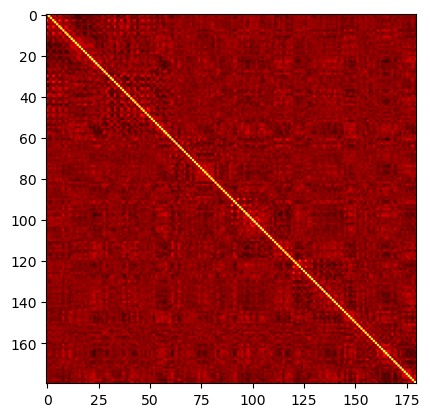

In [32]:
plt.imshow(tracksxtracks[:, :], cmap='hot')
plt.show()

This will be structured as track 1 rep 1, track 1 rep 2, track 1 rep 3, track 2 rep 1, etc. Each column is one track-repetition, and each row corresponds to a specific timepoint at a voxel

Check that it was reshaped correctly. These two should print the same thing.

In [33]:
# track 6, rep 0, voxel 101, timepoints 0-9
sub3test_reshaped[1000:1010, 15] 

array([ 0.09131592,  1.3416682 , -1.3934778 ,  0.09131592, -1.1590365 ,
        2.4357266 , -1.3153307 , -1.6279188 , -1.4716249 , -0.22127223],
      dtype=float32)

In [34]:
print(sub3test.shape)
print(sub3test[100, 0, 50:60])


(64700, 4, 600)
[ 0.11565387  1.3058009  -1.2976459   0.11565387 -1.0744932   2.3471797
 -1.2232617  -1.5207984  -1.3720301  -0.18188292]


In [35]:
test = np.arange(120)
test = test.reshape(2, 3, 20)
# 2 voxels, 3 repetitions, 4 * 5 track timepoints
test.shape

(2, 3, 20)

In [36]:
test_reshaped = np.transpose(test[:, :3, :].reshape(2, 3, 4, 5), [0,3,2,1]).reshape(2*5,4*3)
# voxel * timepoints_per_track, tracks * repetitions

In [37]:
print(test[1, 0, 0:5])
print(test_reshaped[5:10, 0])

# 2 voxels, 3 repetitions, 4 * 5 track timepoints
# 2nd voxel 2nd track 2nd rep
print(test[1, 1, 5:10])
print(test_reshaped[5:10, 4])

[60 61 62 63 64]
[60 61 62 63 64]
[85 86 87 88 89]
[85 86 87 88 89]


sub1test_reshaped format:

(647000, 60): voxels * 10 timepoints, 60 tracks
 
 all timesteps for first voxel, all timesteps for second voxel, stacked. then by track

 need to do that for the first three reptitions. save the last one for testing

 full shape should be (voxels * )

In [38]:
genre_labels[0:10]
genre_180 = np.repeat(genre_labels, 3)

print(genre_180)

[10 10 10  3  3  3  1  1  1  4  4  4  7  7  7  9  9  9  2  2  2  5  5  5
  6  6  6  8  8  8  9  9  9 10 10 10  5  5  5  8  8  8  3  3  3  6  6  6
  1  1  1  2  2  2  4  4  4  7  7  7  5  5  5  1  1  1 10 10 10  3  3  3
  8  8  8  4  4  4  2  2  2  7  7  7  9  9  9  6  6  6  7  7  7  3  3  3
 10 10 10  9  9  9  1  1  1  5  5  5  4  4  4  2  2  2  8  8  8  6  6  6
  8  8  8  3  3  3  2  2  2  7  7  7  4  4  4  5  5  5 10 10 10  1  1  1
  6  6  6  9  9  9  1  1  1  8  8  8  2  2  2  4  4  4  7  7  7  6  6  6
  5  5  5  3  3  3 10 10 10  9  9  9]


In [39]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Move the time dimension to be part of the features
# Result: shape (voxels * timepoints_per_track, tracks)
# X_tracks = reshaped.transpose(0, 1, 2).reshape(voxels * timepoints_per_track, tracks)

clf = LogisticRegression(random_state=0).fit(sub3test_reshaped.T, genre_180)

In [40]:
clf.predict(sub3test_reshaped[:, 0:1].T)

array([10])

In [41]:
genre_180[0]

10

Voxel 26891, Time 6: Weight -0.0020
Voxel 49931, Time 2: Weight 0.0018
Voxel 62490, Time 6: Weight -0.0018
Voxel 55467, Time 0: Weight 0.0018
Voxel 1986, Time 0: Weight 0.0017
Voxel 26892, Time 6: Weight -0.0017
Voxel 62654, Time 1: Weight 0.0017
Voxel 24176, Time 9: Weight 0.0017
Voxel 37793, Time 8: Weight 0.0017
Voxel 1514, Time 2: Weight 0.0017
Voxel 7249, Time 9: Weight -0.0017
Voxel 15040, Time 0: Weight 0.0017
Voxel 1616, Time 4: Weight 0.0017
Voxel 314, Time 4: Weight 0.0017
Voxel 12851, Time 3: Weight -0.0017
Voxel 62629, Time 1: Weight 0.0017
Voxel 9802, Time 0: Weight 0.0016
Voxel 24239, Time 8: Weight 0.0016
Voxel 4187, Time 0: Weight 0.0016
Voxel 16395, Time 1: Weight -0.0016
Voxel 13780, Time 0: Weight 0.0016
Voxel 55795, Time 2: Weight 0.0016
Voxel 13604, Time 0: Weight 0.0016
Voxel 40522, Time 3: Weight -0.0016
Voxel 40050, Time 0: Weight 0.0016
Voxel 10871, Time 0: Weight 0.0016
Voxel 13271, Time 0: Weight 0.0016
Voxel 23069, Time 7: Weight -0.0016
Voxel 24996, Time 0:

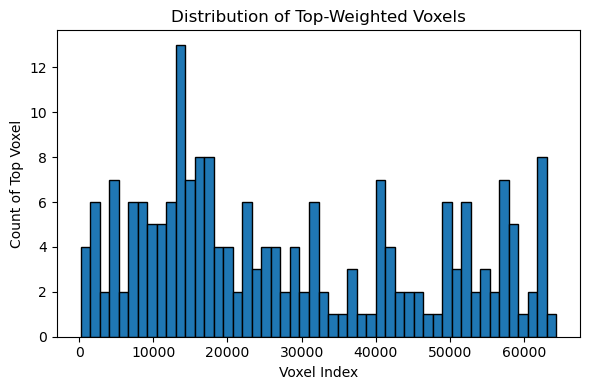

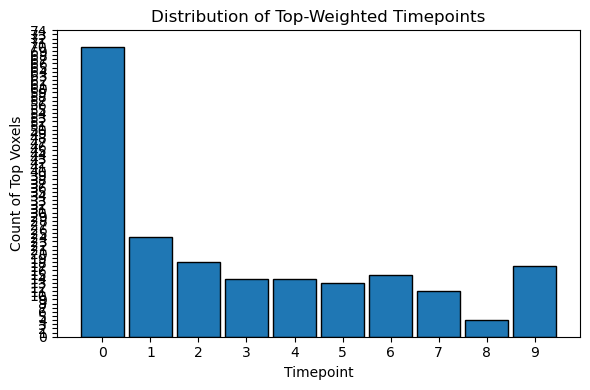

In [62]:
clf.score(sub3test_reshaped.T, genre_180)

import numpy as np

# Step 1: get weight vector
weights = clf.coef_[0]  # (n_features,) for binary classification

# Step 2: get top-N influential feature indices
top_feature_indices = np.argsort(np.abs(weights))[-200:]  # top 100 by absolute weight

# Step 3: convert flat index back to (voxel, timepoint)

for flat_idx in reversed(top_feature_indices):
    voxel_idx = flat_idx // timepoints_per_track
    time_idx = flat_idx % timepoints_per_track
    print(f"Voxel {voxel_idx}, Time {time_idx}: Weight {weights[flat_idx]:.4f}")
    
# Collect all voxel indices from your top features
voxel_indices = [flat_idx // timepoints_per_track for flat_idx in top_feature_indices]

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(voxel_indices, bins=50, edgecolor='black')  # You can change bins=50 as needed
plt.xlabel("Voxel Index")
plt.ylabel("Count of Top Voxel")
plt.title("Distribution of Top-Weighted Voxels")
plt.tight_layout()
plt.show()

# let's only include each voxel once in this list so we can use it for the umap
unique_voxel_indices = np.unique(np.array(top_feature_indices) // 10)
    
# Collect all time indices from your top features
time_indices = [flat_idx % timepoints_per_track for flat_idx in top_feature_indices]

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(time_indices, bins=np.arange(11) - 0.5, edgecolor='black', rwidth=0.9)
plt.xticks(range(10))
plt.yticks(np.arange(0, plt.gca().get_ylim()[1] + 1, 1))
plt.xlabel("Timepoint")
plt.ylabel("Count of Top Voxels")
plt.title("Distribution of Top-Weighted Timepoints")
plt.tight_layout()
plt.show()

In [ ]:
for flat_idx in top_feature_indices:
    voxel = flat_idx // 10
    time = flat_idx % 10
    weight = weights[flat_idx]
    print(f"Voxel {voxel}, Time {time}, Weight {weight:.4f}")
    
filtered_top_indices = [i for i in top_feature_indices if i % 10 in [6, 7, 8, 9]]



Voxel 40922, Time 3, Weight -0.0015
Voxel 41424, Time 6, Weight 0.0015
Voxel 49199, Time 0, Weight 0.0015
Voxel 11853, Time 0, Weight 0.0015
Voxel 10701, Time 9, Weight 0.0015
Voxel 41540, Time 0, Weight 0.0015
Voxel 32085, Time 7, Weight -0.0015
Voxel 8329, Time 0, Weight 0.0015
Voxel 22683, Time 0, Weight 0.0015
Voxel 51513, Time 2, Weight 0.0015
Voxel 2006, Time 9, Weight 0.0015
Voxel 9924, Time 0, Weight 0.0015
Voxel 11582, Time 0, Weight 0.0015
Voxel 47633, Time 0, Weight 0.0015
Voxel 34528, Time 0, Weight 0.0015
Voxel 27009, Time 0, Weight 0.0015
Voxel 49514, Time 2, Weight 0.0015
Voxel 12229, Time 0, Weight 0.0015
Voxel 60966, Time 0, Weight 0.0015
Voxel 35386, Time 1, Weight 0.0015
Voxel 40052, Time 0, Weight 0.0015
Voxel 61982, Time 9, Weight 0.0015
Voxel 27547, Time 9, Weight 0.0015
Voxel 14902, Time 0, Weight 0.0015
Voxel 7768, Time 7, Weight -0.0015
Voxel 36996, Time 6, Weight -0.0015
Voxel 19286, Time 0, Weight 0.0015
Voxel 12755, Time 2, Weight 0.0015
Voxel 62859, Time 1,

inspect the weights to see what it's sensitive to. some weights may be high (timesteps * voxels)

maybe theres a time step or voxel where the weight is particularly high

make a new genre vector to fit the t1r1, t1r2, t1r3, t2t1, etc. Don't need to include time points, because that is already encoded in the reshaped matrix

In [52]:
# Repeat each genre 3 times (for 3 reps)
y = np.repeat(genre_labels, 3)  # length = 180
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Check shape
print("Genre vector shape:", y.shape)
assert y.shape[0] == sub3test_reshaped.T.shape[0], "Mismatch with number of columns in X"

print("Genre labels (first 10):", genre_labels[:10])  # should be per-track
print("y (first 30):", y[:30])  # should repeat each genre 3 times


Genre vector shape: (180,)
Genre labels (first 10): [10, 3, 1, 4, 7, 9, 2, 5, 6, 8]
y (first 30): [10 10 10  3  3  3  1  1  1  4  4  4  7  7  7  9  9  9  2  2  2  5  5  5
  6  6  6  8  8  8]


UMAP on learned weight voxels

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


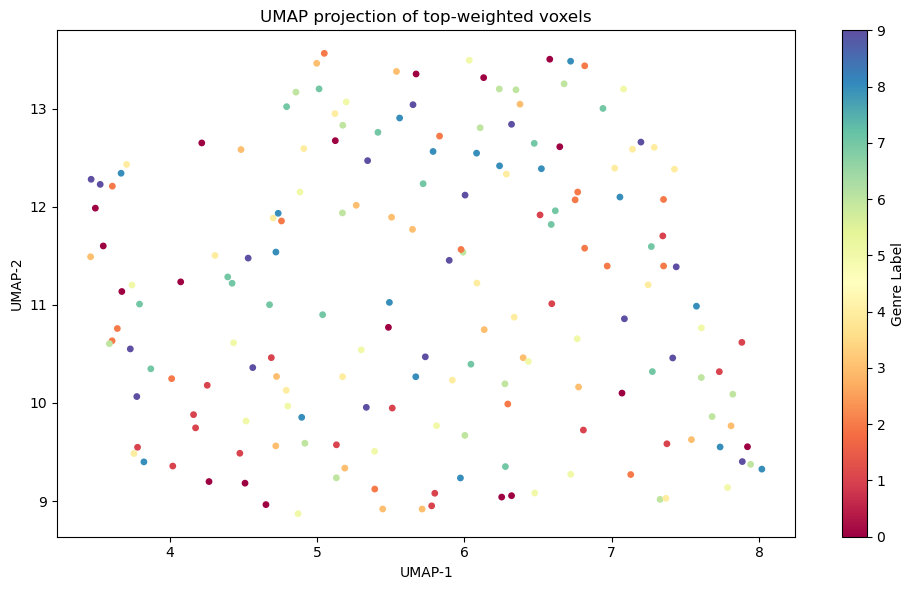

In [53]:
# Subset the original voxel data using top-weighted voxels ---
samples = 180

# Your input matrix
# sub1test_reshaped: shape (647000, 180)

# Compute row indices for timepoints 6–9 of each selected voxel
timepoints_to_avg = np.array([6, 7, 8, 9])
row_indices = unique_voxel_indices[:, None] * timepoints_per_track + timepoints_to_avg  # shape: (n_voxels_kept, 4)

# Extract and average those rows across the timepoint axis
voxel_avg_values = sub3test_reshaped[row_indices, :].mean(axis=1)  # shape: (n_voxels_kept, 180)

# Transpose to shape (samples, voxels)
X_avg = voxel_avg_values.T  # shape: (180, n_voxels_kept)

# --- Step 6: UMAP on PCA output ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X_avg)

# Step 5: Visualize ---
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y_encoded, cmap='Spectral', s=15)
plt.colorbar(scatter, label='Genre Label')
plt.title("UMAP projection of top-weighted voxels")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


Heat map again using only the voxels of interest.

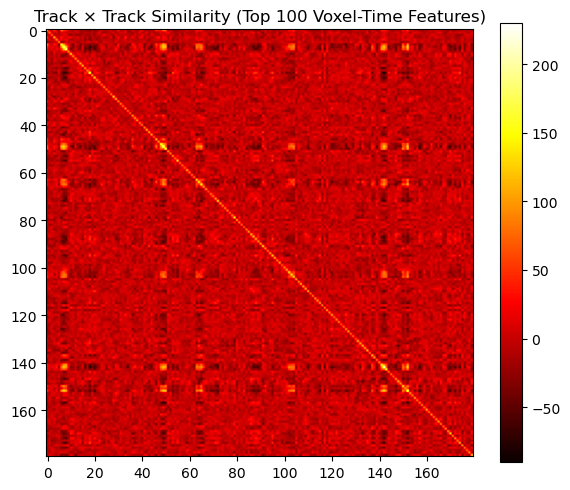

In [50]:
# Step 1: Select only the top voxel-time features
X_top = sub3test_reshaped[top_feature_indices, :]  # shape: (100, 180)

# Step 2: Transpose to shape (180 samples × 100 features)
X_top = X_top.T  # shape: (180, 100)

# Step 3: Z-score across features (columns)
X_top_zscored = (X_top - X_top.mean(axis=0)) / X_top.std(axis=0)

# Step 4: Compute similarity (dot product across samples)
similarity_matrix = X_top_zscored @ X_top_zscored.T  # shape: (180, 180)

# Step 5: Plot heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(similarity_matrix, cmap='hot')
plt.title("Track × Track Similarity (Top 100 Voxel-Time Features)")
plt.colorbar()
plt.tight_layout()
plt.show()
